# **Variational Auto-Encoder**

For our final set of NBs, we will be wrapping up our work on unconditional stable diffusion models. To do this we will be introducing the concept of Variational Auto Encoders to generate our required latents (because Stable Diffusion is, in effect, a _Latent Diffusion_ model).

Perplexity defines VAEs as:

> Variational Autoencoders (VAEs) are a class of generative models in machine learning that combine principles from deep learning and probabilistic graphical models. Introduced by Diederik P. Kingma and Max Welling in 2013, VAEs are designed to learn complex data distributions and generate new data points that resemble the training data.
>
> ### **Architecture of VAEs**
>
> VAEs consist of two main components:
>
> **Encoder**: This neural network compresses input data into a latent representation. Instead of producing a single point in the latent space, the encoder outputs parameters for a probability distribution (typically Gaussian), which describes the latent variables. This probabilistic approach allows VAEs to capture the uncertainty in the data representation1
>
> **Decoder**: The decoder takes samples from the latent distribution and reconstructs the original input data. By sampling from the learned distribution, the decoder can generate new instances of data that are similar but not identical to the training samples.
>
> ### **How VAEs Generate Latents**
> The process of generating latents in VAEs involves several steps:
>
> **Input Data Encoding**: The encoder transforms input data into a probabilistic latent space, represented as **$q(z∣x)$**, where $z$ denotes latent variables and $x$ is the input data.
> 
> **Sampling**: From this distribution, a sample zz is drawn, typically using techniques like reparameterization, which allows gradients to flow through the stochastic part of the model during training.
>
> **Data Reconstruction**: The sampled latent vector zz is fed into the decoder, which reconstructs the input data, aiming to minimize reconstruction loss while adhering to a specified prior distribution (often a standard normal distribution).

The VAE will convert the 256x256, 3 channel images into 32x32x4 latent representations.

In [ ]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [1]:
import os, timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy,Mean,Metric
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from einops import rearrange

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.training import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 80

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus > 8: fc.defaults.cpus=8

In [3]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 256
dsd = load_dataset(name)

In [4]:
@inplace
def transformi(b):
    img = [TF.to_tensor(o).flatten() for o in b[xl]] # Flatten input pixels into a vector
    b[yl] = b[xl] = img

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [5]:
dl = dls.valid
xb, yb = b = next(iter(dl))

## **Setting Up The AutoEncoder**

In [6]:
# Architecture for the autoencoder, featuring number of hidden (nh), number of inputs (ni) 
# and number of outputs i.e. 200. 
ni, nh, nl = 784, 400, 200

In [7]:
# Setup a basic linear layer
def lin(ni, nf, act=nn.SiLU, norm=nn.BatchNorm1d, bias=True):
    layers = nn.Sequential(nn.Linear(ni, nf, bias=bias))
    if act : layers.append(act())
    if norm: layers.append(norm(nf))
    return layers

In [8]:
# Update init_weights to initialize linear layers as well
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [9]:
iw = partial(init_weights, leaky=0.2)

In [10]:
# Creating a regular autoencoder
class Autoenc(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(lin(ni, nh), lin(nh, nh), lin(nh, nl)) # generates latents
        self.dec = nn.Sequential(lin(nl, nh), lin(nh, nh), lin(nh, ni, act=None)) # latents decoded to 784 inputs
        iw(self)

    def forward(self, x):
        x = self.enc(x)
        return self.dec(x)

In [11]:
opt_func = partial(optim.Adam, eps=1e-5)

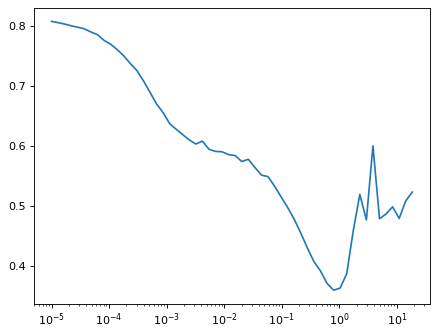

In [12]:
Learner(Autoenc(), dls, nn.BCEWithLogitsLoss(), cbs=[DeviceCB(), MixedPrecision()], opt_func=opt_func).lr_find()

In [ ]:
#del(learn)

In [13]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = Autoenc()
learn = Learner(model, dls, nn.BCEWithLogitsLoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.528,0,train
0.468,0,eval
0.400,1,train
0.350,1,eval
0.316,2,train
0.299,2,eval
0.286,3,train
0.285,3,eval
0.276,4,train
0.276,4,eval


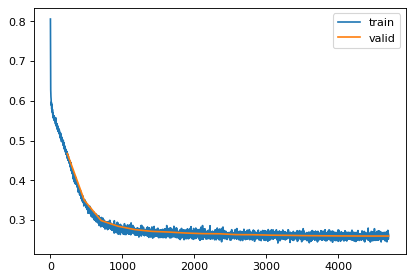

In [14]:
learn.fit(epochs)

## **Sampling From AutoEncoder**

In [18]:
with torch.no_grad(): t = to_cpu(model(xb.cuda()).float())

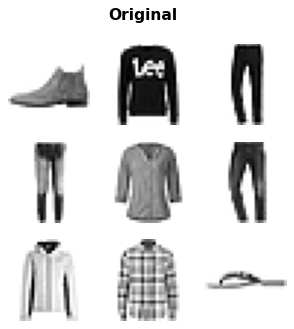

In [19]:
show_images(xb[:9].reshape(-1, 1, 28, 28), imsize=1.5, title='Original')

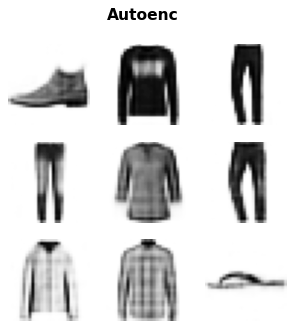

In [20]:
show_images(t[:9].reshape(-1,1,28,28).sigmoid(), imsize=1.5, title='Autoenc');